# 300 - Convolution network, gradient, tweaks, with pytorch

Object detection on [CIFAR10](https://www.kaggle.com/c/cifar-10).

**Note:** install [tqdm](https://pypi.python.org/pypi/tqdm) if not installed: ``!pip install tqdm``

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm

torch 0.2.0_4


In [2]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
DATA_DIR = '/home/xd_ensae/data/'
USE_CUDA = True
N_EPOCHS = 50

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(DATA_DIR, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 64)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
model = Net()
if USE_CUDA: model = model.cuda()

In [6]:
optimizer = optim.Adam(model.parameters())

In [7]:
def train(epoch, verbose=True):
    model.train()
    losses = []
    loader = tqdm(train_loader, total=len(train_loader))
    for batch_idx, (data, target) in enumerate(loader):
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.data[0]))
        if verbose and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    return np.mean(losses)

In [8]:
def test(verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if USE_CUDA: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return [float(test_loss), correct]

In [9]:
perfs = []
for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    train_loss = train(epoch, verbose=False)
    test_loss, correct = test(verbose=False)
    perfs.append([epoch, train_loss, test_loss, correct, len(test_loader.dataset), time.time() - t0])
    print("epoch {}: train loss {:.4f}, test loss {:.4f}, accuracy {}/{} in {:.2f}s".format(*perfs[-1]))

  1%|          | 9/782 [00:00<00:09, 80.81it/s]

epoch 1: train loss 2.1699, test loss 1.7524, accuracy 3675/10000 in 12.01s


  1%|          | 8/782 [00:00<00:09, 78.71it/s]

epoch 2: train loss 1.8401, test loss 1.6206, accuracy 4170/10000 in 11.40s


  1%|          | 8/782 [00:00<00:10, 73.86it/s]

epoch 3: train loss 1.7630, test loss 1.5700, accuracy 4266/10000 in 11.57s


  1%|          | 9/782 [00:00<00:09, 80.37it/s]

epoch 4: train loss 1.7248, test loss 1.5173, accuracy 4500/10000 in 11.88s


  1%|          | 8/782 [00:00<00:09, 79.96it/s]

epoch 5: train loss 1.6856, test loss 1.5035, accuracy 4717/10000 in 11.28s


  1%|          | 8/782 [00:00<00:09, 79.90it/s]

epoch 6: train loss 1.6623, test loss 1.4833, accuracy 4761/10000 in 11.77s


  1%|          | 9/782 [00:00<00:09, 80.12it/s]

epoch 7: train loss 1.6410, test loss 1.4474, accuracy 4833/10000 in 11.40s


  1%|          | 9/782 [00:00<00:09, 80.62it/s]

epoch 8: train loss 1.6247, test loss 1.4428, accuracy 4869/10000 in 11.57s


  1%|          | 8/782 [00:00<00:10, 72.82it/s]

epoch 9: train loss 1.6130, test loss 1.3940, accuracy 4994/10000 in 11.68s


  1%|          | 8/782 [00:00<00:10, 74.79it/s]

epoch 10: train loss 1.6038, test loss 1.3807, accuracy 5107/10000 in 11.62s


  1%|          | 9/782 [00:00<00:09, 80.61it/s]

epoch 11: train loss 1.5972, test loss 1.3783, accuracy 5171/10000 in 11.56s


  1%|          | 8/782 [00:00<00:10, 75.84it/s]

epoch 12: train loss 1.5815, test loss 1.3714, accuracy 5168/10000 in 11.54s


  1%|          | 9/782 [00:00<00:09, 79.67it/s]

epoch 13: train loss 1.5705, test loss 1.3465, accuracy 5320/10000 in 11.86s


  1%|          | 9/782 [00:00<00:09, 81.09it/s]

epoch 14: train loss 1.5621, test loss 1.3515, accuracy 5294/10000 in 11.34s


  1%|          | 8/782 [00:00<00:10, 72.21it/s]

epoch 15: train loss 1.5545, test loss 1.3307, accuracy 5337/10000 in 11.54s


  1%|          | 8/782 [00:00<00:10, 73.62it/s]

epoch 16: train loss 1.5551, test loss 1.3463, accuracy 5409/10000 in 11.83s


  1%|          | 8/782 [00:00<00:10, 76.30it/s]

epoch 17: train loss 1.5352, test loss 1.3289, accuracy 5437/10000 in 11.64s


  1%|          | 7/782 [00:00<00:12, 64.47it/s]

epoch 18: train loss 1.5381, test loss 1.3338, accuracy 5352/10000 in 11.36s


  1%|          | 9/782 [00:00<00:09, 80.71it/s]

epoch 19: train loss 1.5311, test loss 1.3088, accuracy 5489/10000 in 11.85s


  1%|          | 9/782 [00:00<00:09, 80.16it/s]

epoch 20: train loss 1.5289, test loss 1.3119, accuracy 5459/10000 in 11.39s


  1%|          | 9/782 [00:00<00:09, 80.80it/s]

epoch 21: train loss 1.5192, test loss 1.2950, accuracy 5571/10000 in 11.46s


  1%|          | 9/782 [00:00<00:09, 80.24it/s]

epoch 22: train loss 1.5242, test loss 1.2995, accuracy 5499/10000 in 11.48s


  1%|          | 9/782 [00:00<00:09, 80.72it/s]

epoch 23: train loss 1.5155, test loss 1.2938, accuracy 5599/10000 in 11.32s


  1%|          | 8/782 [00:00<00:09, 79.68it/s]

epoch 24: train loss 1.5097, test loss 1.2939, accuracy 5523/10000 in 11.37s


  1%|          | 9/782 [00:00<00:09, 80.95it/s]

epoch 25: train loss 1.5009, test loss 1.2907, accuracy 5525/10000 in 12.07s


  1%|          | 7/782 [00:00<00:12, 63.68it/s]

epoch 26: train loss 1.5020, test loss 1.2845, accuracy 5609/10000 in 11.49s


  1%|          | 8/782 [00:00<00:10, 72.94it/s]

epoch 27: train loss 1.4933, test loss 1.2742, accuracy 5641/10000 in 11.93s


  1%|          | 8/782 [00:00<00:09, 78.93it/s]

epoch 28: train loss 1.4967, test loss 1.2796, accuracy 5583/10000 in 11.58s


  1%|          | 9/782 [00:00<00:09, 80.03it/s]

epoch 29: train loss 1.4880, test loss 1.2805, accuracy 5700/10000 in 11.59s


  1%|          | 8/782 [00:00<00:10, 74.00it/s]

epoch 30: train loss 1.4812, test loss 1.2367, accuracy 5757/10000 in 11.47s


  1%|          | 9/782 [00:00<00:09, 80.74it/s]

epoch 31: train loss 1.4891, test loss 1.2586, accuracy 5648/10000 in 11.49s


  1%|          | 8/782 [00:00<00:09, 78.61it/s]

epoch 32: train loss 1.4858, test loss 1.2723, accuracy 5584/10000 in 11.84s


  1%|          | 8/782 [00:00<00:09, 78.32it/s]

epoch 33: train loss 1.4731, test loss 1.2514, accuracy 5725/10000 in 11.98s


  1%|          | 8/782 [00:00<00:09, 79.99it/s]

epoch 34: train loss 1.4764, test loss 1.2729, accuracy 5765/10000 in 11.62s


  1%|          | 8/782 [00:00<00:09, 78.55it/s]

epoch 35: train loss 1.4606, test loss 1.2519, accuracy 5755/10000 in 11.77s


  1%|          | 9/782 [00:00<00:09, 80.85it/s]

epoch 36: train loss 1.4640, test loss 1.2352, accuracy 5820/10000 in 11.26s


  1%|          | 9/782 [00:00<00:09, 81.90it/s]

epoch 37: train loss 1.4711, test loss 1.2235, accuracy 5779/10000 in 11.55s


  1%|          | 8/782 [00:00<00:09, 79.43it/s]

epoch 38: train loss 1.4510, test loss 1.2238, accuracy 5780/10000 in 11.47s


  1%|          | 9/782 [00:00<00:09, 81.16it/s]

epoch 39: train loss 1.4588, test loss 1.2213, accuracy 5872/10000 in 11.35s


  1%|          | 8/782 [00:00<00:10, 71.97it/s]

epoch 40: train loss 1.4567, test loss 1.2324, accuracy 5788/10000 in 11.74s


  1%|          | 8/782 [00:00<00:09, 78.79it/s]

epoch 41: train loss 1.4502, test loss 1.2370, accuracy 5728/10000 in 11.51s


  1%|          | 8/782 [00:00<00:10, 76.57it/s]

epoch 42: train loss 1.4514, test loss 1.1933, accuracy 5909/10000 in 11.31s


  1%|          | 9/782 [00:00<00:09, 80.75it/s]

epoch 43: train loss 1.4440, test loss 1.2293, accuracy 5890/10000 in 11.77s


  1%|          | 9/782 [00:00<00:09, 80.64it/s]

epoch 44: train loss 1.4462, test loss 1.2149, accuracy 5865/10000 in 11.30s


  1%|          | 9/782 [00:00<00:09, 81.64it/s]

epoch 45: train loss 1.4481, test loss 1.2120, accuracy 5894/10000 in 11.72s


  1%|          | 8/782 [00:00<00:09, 79.71it/s]

epoch 46: train loss 1.4446, test loss 1.2138, accuracy 5854/10000 in 11.68s


  1%|          | 9/782 [00:00<00:09, 81.29it/s]

epoch 47: train loss 1.4439, test loss 1.1978, accuracy 5919/10000 in 11.61s


  1%|          | 8/782 [00:00<00:10, 72.58it/s]

epoch 48: train loss 1.4389, test loss 1.2077, accuracy 5914/10000 in 11.70s


  1%|          | 8/782 [00:00<00:10, 74.84it/s]

epoch 49: train loss 1.4449, test loss 1.1982, accuracy 5958/10000 in 11.50s


100%|██████████| 782/782 [00:10<00:00, 75.38it/s]


epoch 50: train loss 1.4356, test loss 1.2071, accuracy 5910/10000 in 11.86s


In [10]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss", "accuracy", "n_test", "time"])
df_perfs

,epoch,train_loss,test_loss,accuracy,n_test,time
0,1,2.169914,1.752367,3675,10000,12.012165
1,2,1.840080,1.620591,4170,10000,11.397995
2,3,1.763046,1.570013,4266,10000,11.570542
3,4,1.724817,1.517299,4500,10000,11.876798
4,5,1.685609,1.503470,4717,10000,11.277871
5,6,1.662315,1.483279,4761,10000,11.765396
6,7,1.640964,1.447362,4833,10000,11.396923
7,8,1.624725,1.442763,4869,10000,11.572115
8,9,1.613046,1.393994,4994,10000,11.684517
9,10,1.603802,1.380717,5107,10000,11.619156


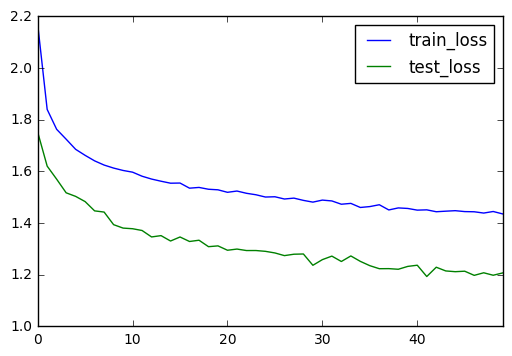

In [11]:
df_perfs[["train_loss", "test_loss"]].plot();